# 알약 판별 EDA

In [1]:
# 노트북 상위 폴더 경로 추가
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 유틸리티 함수 임포트
from src.utils import get_device, init_logger

In [3]:
logger = init_logger(name="healtheat_vision")  # 여기서만 프로젝트 이름을 지정
device = get_device()

logger.info(f"Using device: {device}")

2025-12-09 16:32:53 [INFO] (600008572.py:4) - Using device: mps


Apple MPS GPU detected.


In [7]:
# 1) 데이터 경로 설정
root = "../data/"
logger.info(f"Dataset root set to: {root}")

2025-12-09 16:39:48 [INFO] (1644084871.py:3) - Dataset root set to: ../data/


In [9]:
items = os.listdir(root)

folders = [f for f in items if os.path.isdir(os.path.join(root, f))]
files   = [f for f in items if os.path.isfile(os.path.join(root, f))]

print("Folders:", folders)
print("Files:", files)

Folders: ['test_images', 'train_annotations', 'train_images']
Files: ['.DS_Store', '.gitkeep']


In [12]:
import os
import glob
import json

root = "../data"
img_dir = os.path.join(root, "train_images")
ann_dir = os.path.join(root, "train_annotations")

# 1) 재귀적으로 모든 json 경로 모으기
ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)
print("총 어노테이션 파일 수:", len(ann_paths))
print("예시 경로:", ann_paths[0])

# 2) 한 개만 열어서 구조 확인
with open(ann_paths[0], "r") as f:
    sample_ann = json.load(f)

# 구조 먼저 찍어보자
print(sample_ann.keys())
# 필요하면 전체 구조도:
import pprint
pprint.pp(sample_ann)

총 어노테이션 파일 수: 1001
예시 경로: ../data/train_annotations/K-003351-016232-033880_json/K-003351/K-003351-016232-033880_0_2_0_2_75_000_200.json
dict_keys(['images', 'type', 'annotations', 'categories'])
{'images': [{'file_name': 'K-003351-016232-033880_0_2_0_2_75_000_200.png',
             'width': 976,
             'height': 1280,
             'imgfile': 'K-003351-016232-033880_0_2_0_2_75_000_200.png',
             'drug_N': 'K-003351',
             'drug_S': '정상알약',
             'back_color': '연회색 배경',
             'drug_dir': '앞면',
             'light_color': '주백색',
             'camera_la': 75,
             'camera_lo': 0,
             'size': 200,
             'dl_idx': '3350',
             'dl_mapping_code': 'K-003351',
             'dl_name': '일양하이트린정 2mg',
             'dl_name_en': 'Hytrin Tab. 2mg Ilyang',
             'img_key': 'http://connectdi.com/design/img/drug/147765842976900148.jpg',
             'dl_material': '테라조신염산염수화물',
             'dl_material_en': 'Terazosin Hydrochlo

In [13]:
# 이미지 경로 모으기
img_paths = glob.glob(os.path.join(img_dir, "*.png"))
print("총 이미지 수:", len(img_paths))

def stem(path):
    """경로에서 파일명(확장자 제거)만 반환"""
    return os.path.splitext(os.path.basename(path))[0]

img_dict = {stem(p): p for p in img_paths}
ann_dict = {stem(p): p for p in ann_paths}

# 공통 키 = 실제 매칭되는 샘플
common_keys = sorted(set(img_dict.keys()) & set(ann_dict.keys()))
print("매칭된 이미지-어노테이션 pair 수:", len(common_keys))
print("예시 key:", common_keys[0])
print("이미지 경로:", img_dict[common_keys[0]])
print("어노테이션 경로:", ann_dict[common_keys[0]])

총 이미지 수: 651
매칭된 이미지-어노테이션 pair 수: 232
예시 key: K-001900-016548-019607-029451_0_2_0_2_70_000_200
이미지 경로: ../data/train_images/K-001900-016548-019607-029451_0_2_0_2_70_000_200.png
어노테이션 경로: ../data/train_annotations/K-001900-016548-019607-029451_json/K-019607/K-001900-016548-019607-029451_0_2_0_2_70_000_200.json


In [15]:
import os, glob, json
from collections import Counter
import matplotlib.pyplot as plt

root    = "../data"
img_dir = os.path.join(root, "train_images")
ann_dir = os.path.join(root, "train_annotations")

# 이미지 / 어노테이션 전체 경로
img_paths = glob.glob(os.path.join(img_dir, "*.png"))
ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)

print("이미지 수:", len(img_paths))
print("어노테이션 수:", len(ann_paths))

이미지 수: 651
어노테이션 수: 1001


In [16]:
def stem(path):
    return os.path.splitext(os.path.basename(path))[0]

img_dict = {stem(p): p for p in img_paths}
ann_dict = {}

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)
    img_name = data["images"][0]["file_name"]   # 예: K-003351-..._000_200.png
    key = os.path.splitext(img_name)[0]
    ann_dict[key] = p

common_keys = sorted(set(img_dict.keys()) & set(ann_dict.keys()))
print("매칭된 pair 수:", len(common_keys))
print("예시 key:", common_keys[0])
print("이미지:", img_dict[common_keys[0]])
print("어노테이션:", ann_dict[common_keys[0]])

매칭된 pair 수: 232
예시 key: K-001900-016548-019607-029451_0_2_0_2_70_000_200
이미지: ../data/train_images/K-001900-016548-019607-029451_0_2_0_2_70_000_200.png
어노테이션: ../data/train_annotations/K-001900-016548-019607-029451_json/K-019607/K-001900-016548-019607-029451_0_2_0_2_70_000_200.json


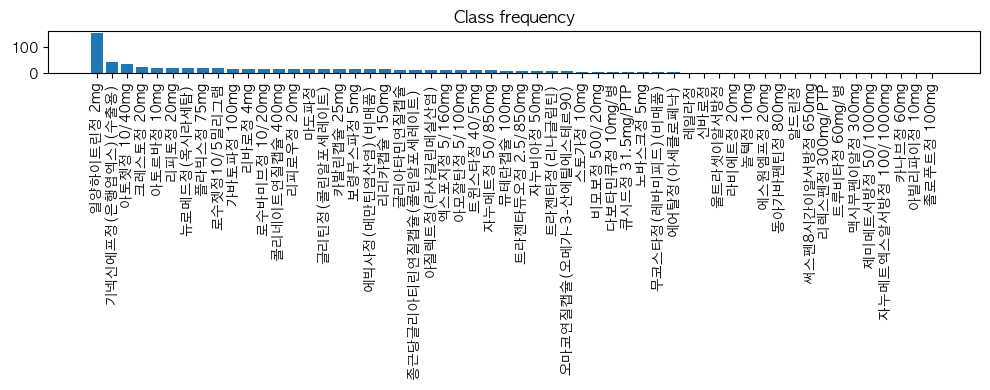

In [28]:
labels, values = zip(*class_counts.most_common())
plt.figure(figsize=(10,4))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.title("Class frequency")
plt.tight_layout()
plt.show()

이미지당 평균 객체 수: 1.0


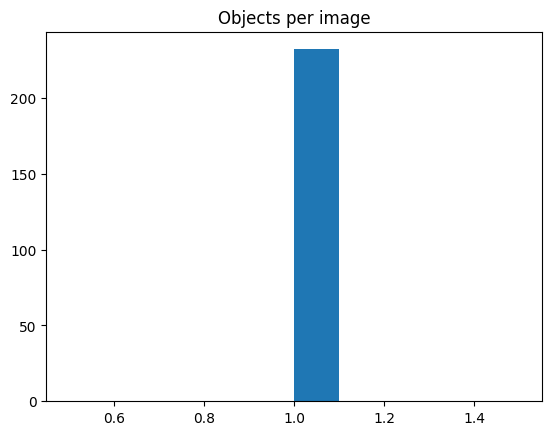

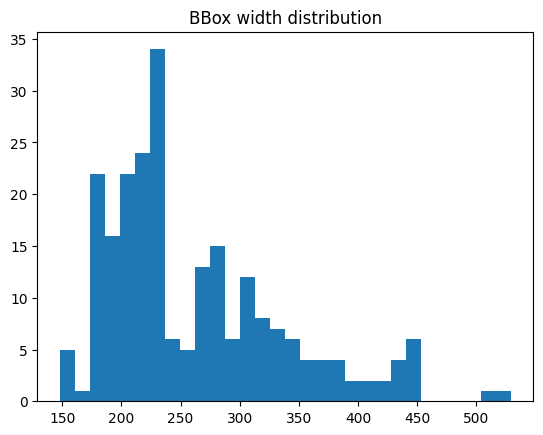

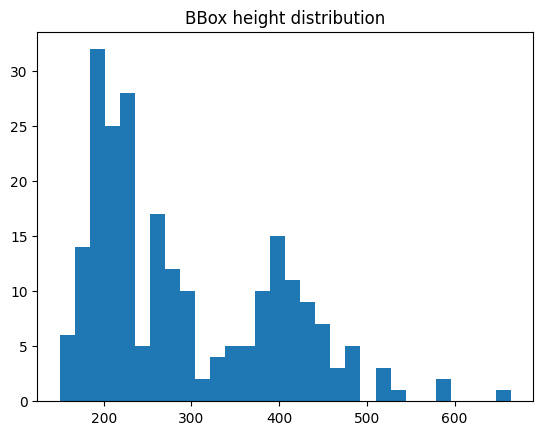

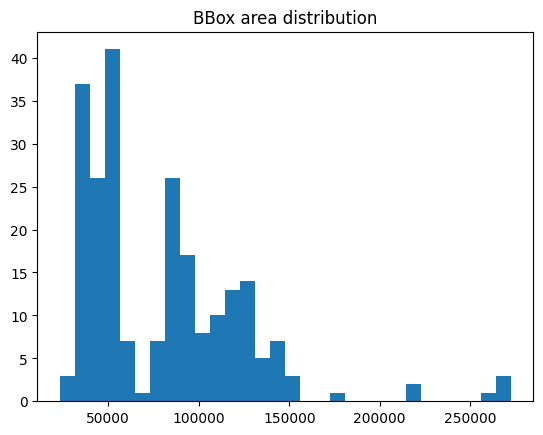

In [19]:
num_objects_per_image = []
widths, heights, areas = [], [], []

for key in common_keys:
    with open(ann_dict[key], "r") as f:
        data = json.load(f)
    anns = data["annotations"]
    
    num_objects_per_image.append(len(anns))
    
    for ann in anns:
        x, y, w, h = ann["bbox"]  # COCO: [x, y, width, height]
        widths.append(w)
        heights.append(h)
        areas.append(ann["area"])

print("이미지당 평균 객체 수:", sum(num_objects_per_image)/len(num_objects_per_image))

plt.hist(num_objects_per_image, bins=10)
plt.title("Objects per image")
plt.show()

plt.hist(widths, bins=30)
plt.title("BBox width distribution")
plt.show()

plt.hist(heights, bins=30)
plt.title("BBox height distribution")
plt.show()

plt.hist(areas, bins=30)
plt.title("BBox area distribution")
plt.show()

# 매칭시도1

In [21]:
import os, glob, json
from collections import Counter
import matplotlib.pyplot as plt

root    = "../data"
img_dir = os.path.join(root, "train_images")
ann_dir = os.path.join(root, "train_annotations")

img_paths = glob.glob(os.path.join(img_dir, "*.png"))
ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)

print("이미지 수:", len(img_paths))     # 651
print("어노테이션 수:", len(ann_paths)) # 1001

def stem(path):
    return os.path.splitext(os.path.basename(path))[0]

# 이미지: key = 파일명(확장자 제거)
img_dict = {stem(p): p for p in img_paths}
img_keys = set(img_dict.keys())

이미지 수: 651
어노테이션 수: 1001


In [22]:
# image_name(확장자 제거) -> [anns...]
image_to_anns = {}
category_id_to_name = {}

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)
    
    img_name = data["images"][0]["file_name"]       # '..._000_200.png'
    key = os.path.splitext(img_name)[0]             # '..._000_200'
    
    # 카테고리 매핑 업데이트
    for cat in data["categories"]:
        category_id_to_name[cat["id"]] = cat["name"]
    
    # 이 JSON에 들어있는 annotation 들 (보통 1개지만 일반형으로 처리)
    for ann in data["annotations"]:
        entry = {
            "bbox": ann["bbox"],
            "category_id": ann["category_id"],
            "area": ann["area"],
            "iscrowd": ann["iscrowd"],
        }
        image_to_anns.setdefault(key, []).append(entry)

print("어노테이션이 존재하는 이미지 수:", len(image_to_anns))

어노테이션이 존재하는 이미지 수: 369


In [23]:
common_keys = sorted(image_to_anns.keys() & img_keys)
print("실제 매칭되는 이미지 수:", len(common_keys))

missing_in_img = sorted(image_to_anns.keys() - img_keys)
missing_in_ann = sorted(img_keys - image_to_anns.keys())

print("어노테이션은 있는데 이미지 없는 개수:", len(missing_in_img))
print("이미지는 있는데 어노테이션 없는 개수:", len(missing_in_ann))

실제 매칭되는 이미지 수: 232
어노테이션은 있는데 이미지 없는 개수: 137
이미지는 있는데 어노테이션 없는 개수: 419


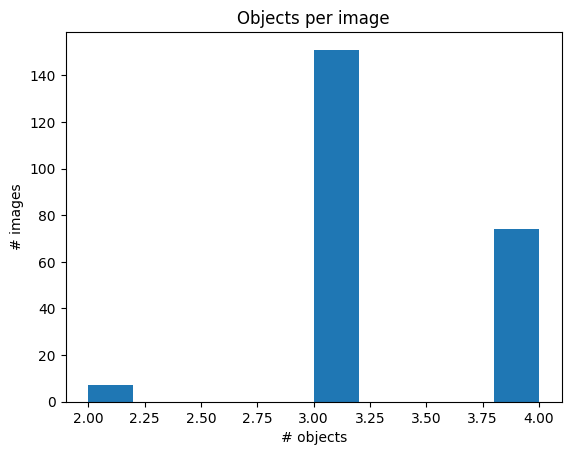

이미지당 평균 객체 수: 3.288793103448276


In [24]:
num_objects_per_image = [
    len(image_to_anns[key]) for key in common_keys
]

plt.hist(num_objects_per_image, bins=10)
plt.title("Objects per image")
plt.xlabel("# objects")
plt.ylabel("# images")
plt.show()

print("이미지당 평균 객체 수:", sum(num_objects_per_image)/len(num_objects_per_image))

In [25]:
class_counts = Counter()

for key in common_keys:
    for ann in image_to_anns[key]:
        cid = ann["category_id"]
        cls_name = category_id_to_name.get(cid, f"id_{cid}")
        class_counts[cls_name] += 1

print("클래스 개수:", len(class_counts))
for cls, cnt in class_counts.most_common(30):
    print(f"{cls:30s} : {cnt}")

클래스 개수: 56
일양하이트린정 2mg                    : 153
기넥신에프정(은행엽엑스)(수출용)             : 45
아토젯정 10/40mg                   : 37
크레스토정 20mg                     : 23
아토르바정 10mg                     : 22
리피토정 20mg                      : 21
뉴로메드정(옥시라세탐)                   : 20
플라빅스정 75mg                     : 20
로수젯정10/5밀리그램                   : 19
가바토파정 100mg                    : 18
리바로정 4mg                       : 18
로수바미브정 10/20mg                 : 18
콜리네이트연질캡슐 400mg                : 17
리피로우정 20mg                     : 16
마도파정                           : 16
글리틴정(콜린알포세레이트)                 : 16
카발린캡슐 25mg                     : 16
보령부스파정 5mg                     : 15
에빅사정(메만틴염산염)(비매품)              : 15
리리카캡슐 150mg                    : 15
글리아타민연질캡슐                      : 14
종근당글리아티린연질캡슐(콜린알포세레이트)         : 13
아질렉트정(라사길린메실산염)                : 12
엑스포지정 5/160mg                  : 12
아모잘탄정 5/100mg                  : 12
트윈스타정 40/5mg                   : 12
자누메트정 50/850mg                 : 12
뮤테란캡슐 100mg     

In [46]:
import pandas as pd

# Counter → DataFrame
df_class_counts = (
    pd.DataFrame(class_counts.items(), columns=["class_name", "count"])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

print(df_class_counts.head(30))

                 class_name  count
0               일양하이트린정 2mg    153
1        기넥신에프정(은행엽엑스)(수출용)     45
2              아토젯정 10/40mg     37
3                크레스토정 20mg     23
4                아토르바정 10mg     22
5                 리피토정 20mg     21
6                플라빅스정 75mg     20
7              뉴로메드정(옥시라세탐)     20
8              로수젯정10/5밀리그램     19
9            로수바미브정 10/20mg     18
10                 리바로정 4mg     18
11              가바토파정 100mg     18
12          콜리네이트연질캡슐 400mg     17
13                     마도파정     16
14               카발린캡슐 25mg     16
15           글리틴정(콜린알포세레이트)     16
16               리피로우정 20mg     16
17               보령부스파정 5mg     15
18              리리카캡슐 150mg     15
19        에빅사정(메만틴염산염)(비매품)     15
20                글리아타민연질캡슐     14
21  종근당글리아티린연질캡슐(콜린알포세레이트)      13
22            엑스포지정 5/160mg     12
23          아질렉트정(라사길린메실산염)     12
24           자누메트정 50/850mg     12
25             트윈스타정 40/5mg     12
26            아모잘탄정 5/100mg     12
27        트라젠타듀오정 2.

In [47]:
df_class_counts[df_class_counts["class_name"].str.contains("세비카")]

,class_name,count


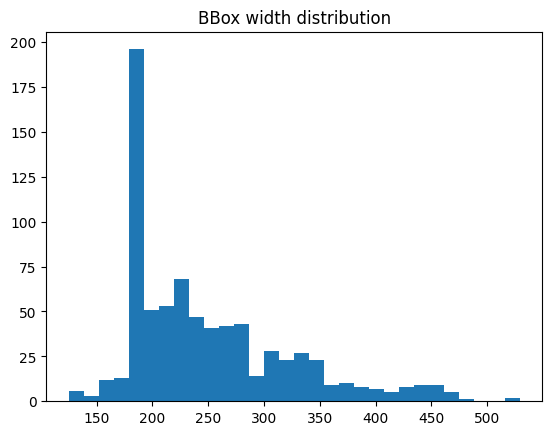

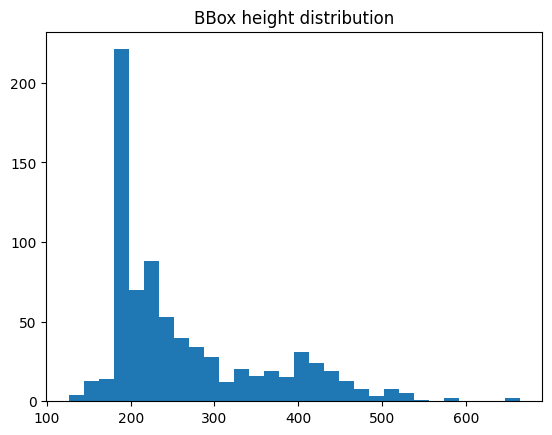

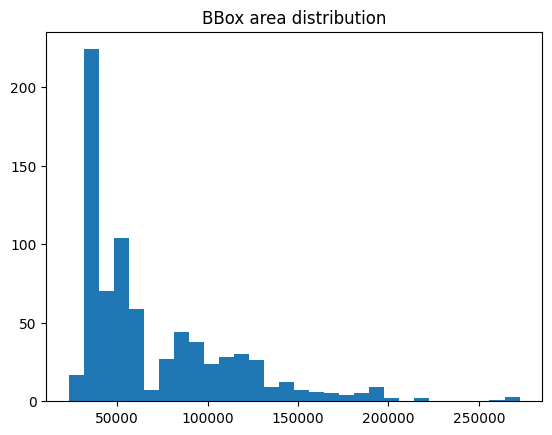

In [26]:
widths, heights, areas = [], [], []

for key in common_keys:
    for ann in image_to_anns[key]:
        x, y, w, h = ann["bbox"]
        widths.append(w)
        heights.append(h)
        areas.append(ann["area"])

plt.hist(widths, bins=30)
plt.title("BBox width distribution")
plt.show()

plt.hist(heights, bins=30)
plt.title("BBox height distribution")
plt.show()

plt.hist(areas, bins=30)
plt.title("BBox area distribution")
plt.show()

In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rc('font', family='AppleGothic')   # 맥: 애플고딕
rcParams['axes.unicode_minus'] = False # 마이너스 깨짐 방지

## 어노테이션 기준 데이터 프레임

In [29]:
import os, glob, json
import pandas as pd

root    = "../data"
img_dir = os.path.join(root, "train_images")
ann_dir = os.path.join(root, "train_annotations")

ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)
print("어노테이션 파일 수:", len(ann_paths))

ann_rows = []

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)
    
    img_info = data["images"][0]
    img_file = img_info["file_name"]               # PNG 파일명
    key      = os.path.splitext(img_file)[0]       # 확장자 제거 키

    cats = {c["id"]: c["name"] for c in data["categories"]}
    anns = data["annotations"]

    cat_ids   = sorted({a["category_id"] for a in anns})
    cat_names = sorted({cats[cid] for cid in cat_ids})

    ann_rows.append({
        "json_path": p,
        "img_file_from_json": img_file,
        "key": key,
        "num_anns_in_json": len(anns),
        "category_ids": cat_ids,
        "category_names": cat_names,
    })

df_ann = pd.DataFrame(ann_rows)
print(df_ann.head())
print("df_ann shape:", df_ann.shape)

어노테이션 파일 수: 1001
                                           json_path  \
0  ../data/train_annotations/K-003351-016232-0338...   
1  ../data/train_annotations/K-003351-016232-0338...   
2  ../data/train_annotations/K-003351-016232-0338...   
3  ../data/train_annotations/K-003351-016232-0338...   
4  ../data/train_annotations/K-003351-016232-0338...   

                              img_file_from_json  \
0  K-003351-016232-033880_0_2_0_2_75_000_200.png   
1  K-003351-016232-033880_0_2_0_2_90_000_200.png   
2  K-003351-016232-033880_0_2_0_2_70_000_200.png   
3  K-003351-016232-033880_0_2_0_2_75_000_200.png   
4  K-003351-016232-033880_0_2_0_2_70_000_200.png   

                                         key  num_anns_in_json category_ids  \
0  K-003351-016232-033880_0_2_0_2_75_000_200                 1       [3350]   
1  K-003351-016232-033880_0_2_0_2_90_000_200                 1       [3350]   
2  K-003351-016232-033880_0_2_0_2_70_000_200                 1       [3350]   
3  K-003351-01623

In [30]:
img_paths = glob.glob(os.path.join(img_dir, "*.png"))
print("이미지 파일 수:", len(img_paths))

img_rows = []
for p in img_paths:
    img_file = os.path.basename(p)
    key = os.path.splitext(img_file)[0]
    img_rows.append({
        "img_path": p,
        "img_file": img_file,
        "key": key,
    })

df_img = pd.DataFrame(img_rows)
print(df_img.head())
print("df_img shape:", df_img.shape)

이미지 파일 수: 651
                                            img_path  \
0  ../data/train_images/K-003544-006563-012247-01...   
1  ../data/train_images/K-002483-004378-019552-02...   
2  ../data/train_images/K-003483-025367-027733-03...   
3  ../data/train_images/K-001900-016548-018110-03...   
4  ../data/train_images/K-003483-016232-025469-03...   

                                            img_file  \
0  K-003544-006563-012247-016548_0_2_0_2_90_000_2...   
1  K-002483-004378-019552-025438_0_2_0_2_70_000_2...   
2  K-003483-025367-027733-035206_0_2_0_2_75_000_2...   
3  K-001900-016548-018110-031705_0_2_0_2_75_000_2...   
4  K-003483-016232-025469-031885_0_2_0_2_90_000_2...   

                                                key  
0  K-003544-006563-012247-016548_0_2_0_2_90_000_200  
1  K-002483-004378-019552-025438_0_2_0_2_70_000_200  
2  K-003483-025367-027733-035206_0_2_0_2_75_000_200  
3  K-001900-016548-018110-031705_0_2_0_2_75_000_200  
4  K-003483-016232-025469-031885_0_2_0_2_9

count    369.000000
mean       2.712737
std        0.896173
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: count, dtype: float64
key
K-003483-025367-027733-029667_0_2_0_2_70_000_200    4
K-003483-020877-031885-036637_0_2_0_2_75_000_200    4
K-003483-016232-022347-025469_0_2_0_2_90_000_200    4
K-003483-025469-028763-035206_0_2_0_2_75_000_200    4
K-003483-025469-028763-035206_0_2_0_2_90_000_200    4
K-003483-025469-028763-035206_0_2_0_2_70_000_200    4
K-003483-016232-022347-025469_0_2_0_2_70_000_200    4
K-003483-020238-027733-028763_0_2_0_2_75_000_200    4
K-003483-020238-027733-028763_0_2_0_2_90_000_200    4
K-003483-020238-027733-028763_0_2_0_2_70_000_200    4
K-001900-016548-019607-033009_0_2_0_2_75_000_200    4
K-002483-003743-012778-013395_0_2_0_2_70_000_200    4
K-003483-025367-025469-035206_0_2_0_2_75_000_200    4
K-003483-025367-025469-035206_0_2_0_2_70_000_200    4
K-003483-025367-025469-035206_0_2_0_2_90_000_200    

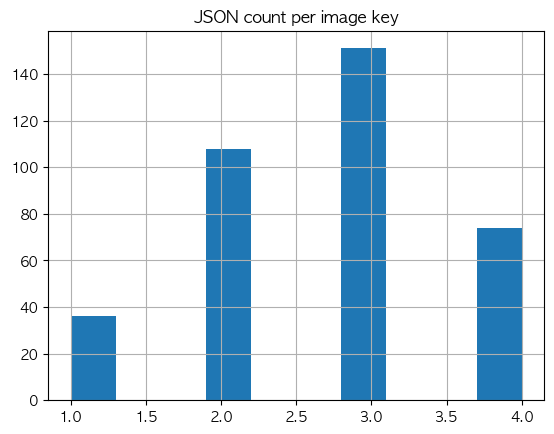

In [35]:
# 이미지 키 기준 JSON 개수
key_counts = df_ann["key"].value_counts()
print(key_counts.describe())     # 평균, 최대 등
print(key_counts.head(20))      # 상위 20개

# 분포 히스토그램
key_counts.hist(bins=10)
plt.title("JSON count per image key")
plt.show()

In [36]:
# 어노테이션에서 참조하는 고유 이미지 key 수
n_unique_keys_in_ann = df_ann["key"].nunique()
print("JSON에서 참조하는 고유 이미지 key 개수:", n_unique_keys_in_ann)

# 실제 값 확인
key_counts = df_ann["key"].value_counts()
print(key_counts.describe())      # 평균, 최대 등 통계
print(key_counts.head(20))       # 상위 20개 (어노테이션 많이 달린 이미지)

JSON에서 참조하는 고유 이미지 key 개수: 369
count    369.000000
mean       2.712737
std        0.896173
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: count, dtype: float64
key
K-003483-025367-027733-029667_0_2_0_2_70_000_200    4
K-003483-020877-031885-036637_0_2_0_2_75_000_200    4
K-003483-016232-022347-025469_0_2_0_2_90_000_200    4
K-003483-025469-028763-035206_0_2_0_2_75_000_200    4
K-003483-025469-028763-035206_0_2_0_2_90_000_200    4
K-003483-025469-028763-035206_0_2_0_2_70_000_200    4
K-003483-016232-022347-025469_0_2_0_2_70_000_200    4
K-003483-020238-027733-028763_0_2_0_2_75_000_200    4
K-003483-020238-027733-028763_0_2_0_2_90_000_200    4
K-003483-020238-027733-028763_0_2_0_2_70_000_200    4
K-001900-016548-019607-033009_0_2_0_2_75_000_200    4
K-002483-003743-012778-013395_0_2_0_2_70_000_200    4
K-003483-025367-025469-035206_0_2_0_2_75_000_200    4
K-003483-025367-025469-035206_0_2_0_2_70_000_200    4
K-003483-025367-02546

In [33]:
ann_keys = set(df_ann["key"])
img_keys = set(df_img["key"])

common_keys      = ann_keys & img_keys
ann_only_keys    = ann_keys - img_keys   # 어노테이션만 있고 이미지 없음
img_only_keys    = img_keys - ann_keys   # 이미지만 있고 어노테이션 없음

print("실제 매칭되는 이미지 수:", len(common_keys))
print("어노테이션만 있는 키 수:", len(ann_only_keys))
print("이미지만 있는 키 수:", len(img_only_keys))

실제 매칭되는 이미지 수: 232
어노테이션만 있는 키 수: 137
이미지만 있는 키 수: 419


In [34]:
df_ann_only = df_ann[df_ann["key"].isin(ann_only_keys)].copy()
df_img_only = df_img[df_img["key"].isin(img_only_keys)].copy()

print("=== 어노테이션만 있는데 이미지 없는 케이스 예시 ===")
print(df_ann_only.head(10)[["key", "img_file_from_json", "json_path", "category_names"]])

print("=== 이미지만 있고 어노테이션 없는 케이스 예시 ===")
print(df_img_only.head(10)[["key", "img_file", "img_path"]])

=== 어노테이션만 있는데 이미지 없는 케이스 예시 ===
                                          key  \
1   K-003351-016232-033880_0_2_0_2_90_000_200   
2   K-003351-016232-033880_0_2_0_2_70_000_200   
4   K-003351-016232-033880_0_2_0_2_70_000_200   
6   K-003351-016232-033880_0_2_0_2_90_000_200   
8   K-003351-035206-041768_0_2_0_2_75_000_200   
15  K-003351-013900-029667_0_2_0_2_75_000_200   
21  K-003351-016688-020014_0_2_0_2_70_000_200   
23  K-003351-016688-020014_0_2_0_2_75_000_200   
25  K-003351-016688-020014_0_2_0_2_75_000_200   
63  K-003351-018147-036637_0_2_0_2_75_000_200   

                               img_file_from_json  \
1   K-003351-016232-033880_0_2_0_2_90_000_200.png   
2   K-003351-016232-033880_0_2_0_2_70_000_200.png   
4   K-003351-016232-033880_0_2_0_2_70_000_200.png   
6   K-003351-016232-033880_0_2_0_2_90_000_200.png   
8   K-003351-035206-041768_0_2_0_2_75_000_200.png   
15  K-003351-013900-029667_0_2_0_2_75_000_200.png   
21  K-003351-016688-020014_0_2_0_2_70_000_200.png   
23 

In [37]:
ann_keys = set(df_ann["key"])
img_keys = set(df_img["key"])

ann_only_keys = ann_keys - img_keys     # 어노테이션은 있는데 이미지 없음
print("어노테이션만 있고 매칭 안된 key 수:", len(ann_only_keys))  # 164 확인

어노테이션만 있고 매칭 안된 key 수: 137


In [38]:
df_ann_only = df_ann[df_ann["key"].isin(ann_only_keys)].copy()
print(df_ann_only.shape)
df_ann_only.head()

(238, 6)


,json_path,img_file_from_json,key,num_anns_in_json,category_ids,category_names
1,../data/train_annotations/K-003351-016232-0338...,K-003351-016232-033880_0_2_0_2_90_000_200.png,K-003351-016232-033880_0_2_0_2_90_000_200,1,[3350],[일양하이트린정 2mg]
2,../data/train_annotations/K-003351-016232-0338...,K-003351-016232-033880_0_2_0_2_70_000_200.png,K-003351-016232-033880_0_2_0_2_70_000_200,1,[3350],[일양하이트린정 2mg]
4,../data/train_annotations/K-003351-016232-0338...,K-003351-016232-033880_0_2_0_2_70_000_200.png,K-003351-016232-033880_0_2_0_2_70_000_200,1,[16231],[리피토정 20mg]
6,../data/train_annotations/K-003351-016232-0338...,K-003351-016232-033880_0_2_0_2_90_000_200.png,K-003351-016232-033880_0_2_0_2_90_000_200,1,[33879],[글리틴정(콜린알포세레이트)]
8,../data/train_annotations/K-003351-035206-0417...,K-003351-035206-041768_0_2_0_2_75_000_200.png,K-003351-035206-041768_0_2_0_2_75_000_200,1,[3350],[일양하이트린정 2mg]


In [39]:
df_ann_only["prefix15"] = df_ann_only["key"].str.slice(0, 15)
print(df_ann_only["prefix15"].value_counts().head(20))

prefix15
K-003351-016232    23
K-003351-013900    23
K-003351-016688    23
K-003351-018357    21
K-003351-003832    18
K-003351-020014    18
K-003351-016262    18
K-003351-018147    17
K-003351-019232    13
K-003351-031863    12
K-003351-022074    12
K-003351-029667    10
K-003351-020238     9
K-003351-033880     8
K-003351-032310     5
K-003351-021325     3
K-003351-036637     2
K-003351-038162     2
K-003351-035206     1
Name: count, dtype: int64


In [40]:
df_ann_only["suffix"] = df_ann_only["key"].str.extract(r'(_\d+_\d+_\d+_\d+_\d+_\d+_\d+)$')
print(df_ann_only["suffix"].value_counts().head(20))

suffix
_0_2_0_2_70_000_200    90
_0_2_0_2_75_000_200    80
_0_2_0_2_90_000_200    67
_0_2_1_2_70_000_200     1
Name: count, dtype: int64


In [41]:
df_ann_only["cat"] = df_ann_only["category_names"].apply(lambda x: x[0] if x else None)

print(df_ann_only["cat"].value_counts().head(20))

cat
일양하이트린정 2mg                 87
리바로정 4mg                    11
아질렉트정(라사길린메실산염)             11
리피로우정 20mg                  10
콜리네이트연질캡슐 400mg              9
종근당글리아티린연질캡슐(콜린알포세레이트)       9
에빅사정(메만틴염산염)(비매품)            9
플라빅스정 75mg                   9
로수바미브정 10/20mg               9
오마코연질캡슐(오메가-3-산에틸에스테르90)     8
리리카캡슐 150mg                  8
크레스토정 20mg                   8
리피토정 20mg                    8
뉴로메드정(옥시라세탐)                 7
마도파정                         7
카발린캡슐 25mg                   7
로수젯정10/5밀리그램                 5
글리틴정(콜린알포세레이트)               5
글리아타민연질캡슐                    4
아토르바정 10mg                   4
Name: count, dtype: int64


In [42]:
df_ann_only["json_suffix"] = df_ann_only["img_file_from_json"].str.extract(r'(_\d+_\d+_\d+_\d+_\d+_\d+_\d+)\.png')
print(df_ann_only["json_suffix"].value_counts().head(20))

json_suffix
_0_2_0_2_70_000_200    90
_0_2_0_2_75_000_200    80
_0_2_0_2_90_000_200    67
_0_2_1_2_70_000_200     1
Name: count, dtype: int64


In [43]:
df_ann_only["img_file_from_json"].str.len().value_counts()

img_file_from_json
45    238
Name: count, dtype: int64

In [45]:
import os
import glob
import json
import pandas as pd

# ======================
# 0. 경로 설정
# ======================
root    = "../data"
img_dir = os.path.join(root, "train_images")
ann_dir = os.path.join(root, "train_annotations")

# ======================
# 1. 이미지 목록 수집
# ======================
img_paths = glob.glob(os.path.join(img_dir, "*.png"))
print("이미지 파일 수:", len(img_paths))

def stem(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]

img_rows = []
for p in img_paths:
    img_file = os.path.basename(p)
    key = stem(p)
    img_rows.append({
        "img_key": key,
        "img_file": img_file,
        "img_path": p,
    })

df_img = pd.DataFrame(img_rows)
img_keys = set(df_img["img_key"])
print("df_img shape:", df_img.shape)


# ======================
# 2. 어노테이션(JSON) → DataFrame
# ======================
ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)
print("어노테이션 JSON 파일 수:", len(ann_paths))

ann_rows = []

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)

    # 이미지 정보
    img_info = data["images"][0]
    img_file_from_json = img_info["file_name"]          # PNG 파일명
    key = os.path.splitext(img_file_from_json)[0]       # 확장자 제거 key

    # 카테고리 매핑 (id → name)
    cats = {c["id"]: c["name"] for c in data["categories"]}

    # 어노테이션 리스트
    anns = data["annotations"]
    num_anns = len(anns)
    cat_ids   = sorted({a["category_id"] for a in anns})
    cat_names = sorted({cats[cid] for cid in cat_ids})

    # 이미지 매칭 여부
    has_image = key in img_keys
    matched_img_path = df_img.loc[df_img["img_key"] == key, "img_path"].iloc[0] if has_image else None

    ann_rows.append({
        "json_path": p,
        "img_file_from_json": img_file_from_json,
        "img_key": key,
        "num_anns_in_json": num_anns,
        "category_ids": cat_ids,
        "category_names": cat_names,
        "has_image_match": has_image,
        "matched_img_path": matched_img_path,
    })

df_ann = pd.DataFrame(ann_rows)
print("df_ann shape:", df_ann.shape)

# ======================
# 3. 매칭統계 확인
# ======================
n_unique_keys_in_ann = df_ann["img_key"].nunique()
print("어노테이션에서 참조하는 고유 이미지 key 수:", n_unique_keys_in_ann)

ann_keys = set(df_ann["img_key"])
common_keys   = ann_keys & img_keys
ann_only_keys = ann_keys - img_keys
img_only_keys = img_keys - ann_keys

print("매칭된 이미지 수 (common_keys):", len(common_keys))
print("어노테이션만 있고 이미지 없는 key 수:", len(ann_only_keys))
print("이미지만 있고 어노테이션 없는 key 수:", len(img_only_keys))


# ======================
# 4. CSV로 저장
# ======================
# 4-1) json 기준 summary CSV
csv_path = "pill_annotations_with_match_info.csv"
df_ann.to_csv(csv_path, index=False)
print(f"어노테이션+매칭정보 CSV 저장 완료 → {csv_path}")

# 4-2) 이미지 목록 CSV (원하면)
csv_img_path = "pill_images_list.csv"
df_img.to_csv(csv_img_path, index=False)
print(f"이미지 목록 CSV 저장 완료 → {csv_img_path}")


# ======================
# 5. 클래스 단위 매칭 여부 집계 (pivot 느낌)
# ======================
# category_names는 리스트이므로 explode로 풀기
df_cat = df_ann.explode("category_names").copy()
df_cat.rename(columns={"category_names": "category_name"}, inplace=True)

# 클래스별:
#   - total_json_cnt: JSON row 수
#   - json_with_image_cnt: 매칭된 JSON 수
#   - has_any_image_match: 그 클래스가 최소 1개라도 이미지와 매칭됨?
class_summary = (
    df_cat
    .groupby("category_name")
    .agg(
        total_json_cnt=("json_path", "count"),
        json_with_image_cnt=("has_image_match", lambda s: s.sum()),
    )
    .reset_index()
)

class_summary["has_any_image_match"] = class_summary["json_with_image_cnt"] > 0

# 전체 클래스 요약 CSV
csv_class_path = "pill_class_match_summary.csv"
class_summary.to_csv(csv_class_path, index=False)
print(f"클래스 단위 매칭 요약 CSV 저장 완료 → {csv_class_path}")

# ======================
# 6. "매칭이 아예 안된 알약 클래스"만 추출
# ======================
df_unmatched_class = class_summary[class_summary["has_any_image_match"] == False].copy()
print("\n=== 매칭이 1개도 안 된 알약 클래스 목록 ===")
print(df_unmatched_class)

csv_unmatched_class_path = "pill_unmatched_classes.csv"
df_unmatched_class.to_csv(csv_unmatched_class_path, index=False)
print(f"매칭 안된 클래스 CSV 저장 완료 → {csv_unmatched_class_path}")

이미지 파일 수: 651
df_img shape: (651, 3)
어노테이션 JSON 파일 수: 1001
df_ann shape: (1001, 8)
어노테이션에서 참조하는 고유 이미지 key 수: 369
매칭된 이미지 수 (common_keys): 232
어노테이션만 있고 이미지 없는 key 수: 137
이미지만 있고 어노테이션 없는 key 수: 419
어노테이션+매칭정보 CSV 저장 완료 → pill_annotations_with_match_info.csv
이미지 목록 CSV 저장 완료 → pill_images_list.csv
클래스 단위 매칭 요약 CSV 저장 완료 → pill_class_match_summary.csv

=== 매칭이 1개도 안 된 알약 클래스 목록 ===
Empty DataFrame
Columns: [category_name, total_json_cnt, json_with_image_cnt, has_any_image_match]
Index: []
매칭 안된 클래스 CSV 저장 완료 → pill_unmatched_classes.csv


## 데이터 로드

## 어노테이션 파일

In [49]:
# ============================================
# 1) 어노테이션(JSON) 전체에서 클래스 카운트 추출
#    - 이미지 매칭 여부와 관계 없이 어노테이션만 기준
# ============================================

import json
import os
import glob
from collections import Counter
import pandas as pd

root    = "../data"
ann_dir = os.path.join(root, "train_annotations")

# 모든 json 파일 불러오기
ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)

category_id_to_name = {}

# 전체 클래스 카운트
class_counter = Counter()

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)

    # categories 는 JSON마다 들어 있으므로 계속 업데이트
    for cat in data["categories"]:
        category_id_to_name[cat["id"]] = cat["name"]

    # annotations 내부 category_id로 카운트
    for ann in data["annotations"]:
        cid = ann["category_id"]
        cname = category_id_to_name.get(cid, f"id_{cid}")
        class_counter[cname] += 1


# ============================================
# 2) Counter → DataFrame 변환
# ============================================

df_class_counts = (
    pd.DataFrame(class_counter.items(), columns=["class_name", "count"])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

print(df_class_counts.head())


# ============================================
# 3) CSV 파일로 저장
# ============================================

output_path = "annotation_only_class_counts.csv"
df_class_counts.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"[완료] 어노테이션 기준 클래스 카운트 CSV 저장됨 → {output_path}")

           class_name  count
0         일양하이트린정 2mg    240
1  기넥신에프정(은행엽엑스)(수출용)     45
2        아토젯정 10/40mg     40
3          크레스토정 20mg     31
4          플라빅스정 75mg     29
[완료] 어노테이션 기준 클래스 카운트 CSV 저장됨 → annotation_only_class_counts.csv


In [50]:
# ============================================
# [A] 어노테이션 전체에서 등장하는 고유 클래스 리스트 + 카운트
# ============================================

import json
import os
import glob
from collections import Counter
import pandas as pd

root    = "../data"
ann_dir = os.path.join(root, "train_annotations")

# 모든 json 파일 불러오기
ann_paths = glob.glob(os.path.join(ann_dir, "**", "*.json"), recursive=True)

category_id_to_name = {}
class_counter = Counter()

for p in ann_paths:
    with open(p, "r") as f:
        data = json.load(f)

    # category_id → name 매핑
    for cat in data["categories"]:
        category_id_to_name[cat["id"]] = cat["name"]

    # annotation 기준 카운트
    for ann in data["annotations"]:
        cid = ann["category_id"]
        cname = category_id_to_name.get(cid, f"id_{cid}")
        class_counter[cname] += 1


# ============================================
# [B] 고유 클래스 리스트 추출
# ============================================

unique_classes = sorted(class_counter.keys())
num_unique_classes = len(unique_classes)

print(f"고유 클래스 개수: {num_unique_classes}")
print("고유 클래스 리스트 일부:")
print(unique_classes[:20])   # 필요하면 전체 표시 가능


# ============================================
# [C] 클래스별 카운트 DataFrame
# ============================================

df_class_counts = (
    pd.DataFrame(class_counter.items(), columns=["class_name", "count"])
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)

print(df_class_counts.head())


# ============================================
# [D] CSV로 저장
# ============================================

csv_unique_path = "annotation_unique_classes.csv"
csv_count_path  = "annotation_class_counts.csv"

# 고유 클래스 리스트 저장
pd.DataFrame({"class_name": unique_classes}).to_csv(
    csv_unique_path, index=False, encoding="utf-8-sig"
)

# 클래스별 카운트 저장
df_class_counts.to_csv(
    csv_count_path, index=False, encoding="utf-8-sig"
)

print(f"[완료] 고유 클래스 리스트 CSV 저장 → {csv_unique_path}")
print(f"[완료] 클래스별 카운트 CSV 저장 → {csv_count_path}")

고유 클래스 개수: 56
고유 클래스 리스트 일부:
['가바토파정 100mg', '글리아타민연질캡슐', '글리틴정(콜린알포세레이트)', '기넥신에프정(은행엽엑스)(수출용)', '노바스크정 5mg', '놀텍정 10mg', '뉴로메드정(옥시라세탐)', '다보타민큐정 10mg/병', '동아가바펜틴정 800mg', '라비에트정 20mg', '레일라정', '로수바미브정 10/20mg', '로수젯정10/5밀리그램', '리렉스펜정 300mg/PTP', '리리카캡슐 150mg', '리바로정 4mg', '리피로우정 20mg', '리피토정 20mg', '마도파정', '맥시부펜이알정 300mg']
           class_name  count
0         일양하이트린정 2mg    240
1  기넥신에프정(은행엽엑스)(수출용)     45
2        아토젯정 10/40mg     40
3          크레스토정 20mg     31
4          플라빅스정 75mg     29
[완료] 고유 클래스 리스트 CSV 저장 → annotation_unique_classes.csv
[완료] 클래스별 카운트 CSV 저장 → annotation_class_counts.csv
